In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.python.lib.io import file_io

# Path to the TFRecord file in GCS
tfrecord_path = "gs://max-us-central2/susieprocessed_tfrecords_4step/training/A/traj76.tfrecord"
# tfrecord_path = "gs://max-us-central2/calvin_language_conditioned_tfrecords/training/B/traj0.tfrecord"

# Function to parse the TFRecord
def parse_tfrecord(example_proto):
    """Parse a single TFRecord example."""
    feature_description = {
        'actions': tf.io.FixedLenFeature([], tf.string),
        'proprioceptive_states': tf.io.FixedLenFeature([], tf.string),
        'image_states': tf.io.FixedLenFeature([], tf.string),
        'language_annotation': tf.io.FixedLenFeature([], tf.string),
        'susie_goal_images': tf.io.FixedLenFeature([], tf.string),
    }
    
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    # Deserialize tensors
    actions = tf.io.parse_tensor(parsed_features['actions'], out_type=tf.float32)
    proprioceptive_states = tf.io.parse_tensor(parsed_features['proprioceptive_states'], out_type=tf.float32)
    image_states = tf.io.parse_tensor(parsed_features['image_states'], out_type=tf.uint8)
    language_annotation = parsed_features['language_annotation']
    susie_goal_images = tf.io.parse_tensor(parsed_features['susie_goal_images'], out_type=tf.uint8)
    
    return {
        'actions': actions,
        'proprioceptive_states': proprioceptive_states,
        'image_states': image_states,
        'language_annotation': language_annotation,
        'susie_goal_images': susie_goal_images
    }

# Load the TFRecord
dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord)

# Get the first (and only) trajectory
trajectory = next(iter(dataset))

print("Trajectory loaded successfully!")
print(f"\nLanguage annotation: {trajectory['language_annotation'].numpy().decode('utf-8')}")
print(f"Actions shape: {trajectory['actions'].shape}")
print(f"Proprioceptive states shape: {trajectory['proprioceptive_states'].shape}")
print(f"Image states shape: {trajectory['image_states'].shape}")
print(f"SUSIE goal images shape: {trajectory['susie_goal_images'].shape}")

Trajectory loaded successfully!

Language annotation: move the door all the way to the left
Actions shape: (65, 7)
Proprioceptive states shape: (65, 15)
Image states shape: (65, 200, 200, 3)
SUSIE goal images shape: (65, 200, 200, 3)


In [10]:
# Convert to numpy arrays for easier manipulation
actions = trajectory['actions'].numpy()
proprioceptive_states = trajectory['proprioceptive_states'].numpy()
image_states = trajectory['image_states'].numpy()
susie_goal_images = trajectory['susie_goal_images'].numpy()
language_annotation = trajectory['language_annotation'].numpy().decode('utf-8')

print(f"Language instruction: '{language_annotation}'")
print(f"\nTrajectory length: {len(actions)} timesteps")
print(f"Action dimension: {actions.shape[1]}")
print(f"Proprioceptive state dimension: {proprioceptive_states.shape[1]}")
print(f"Image resolution: {image_states.shape[1:3]}")
print(f"SUSIE goal image resolution: {susie_goal_images.shape[1:3]}")

Language instruction: 'move the door all the way to the left'

Trajectory length: 65 timesteps
Action dimension: 7
Proprioceptive state dimension: 15
Image resolution: (200, 200)
SUSIE goal image resolution: (200, 200)


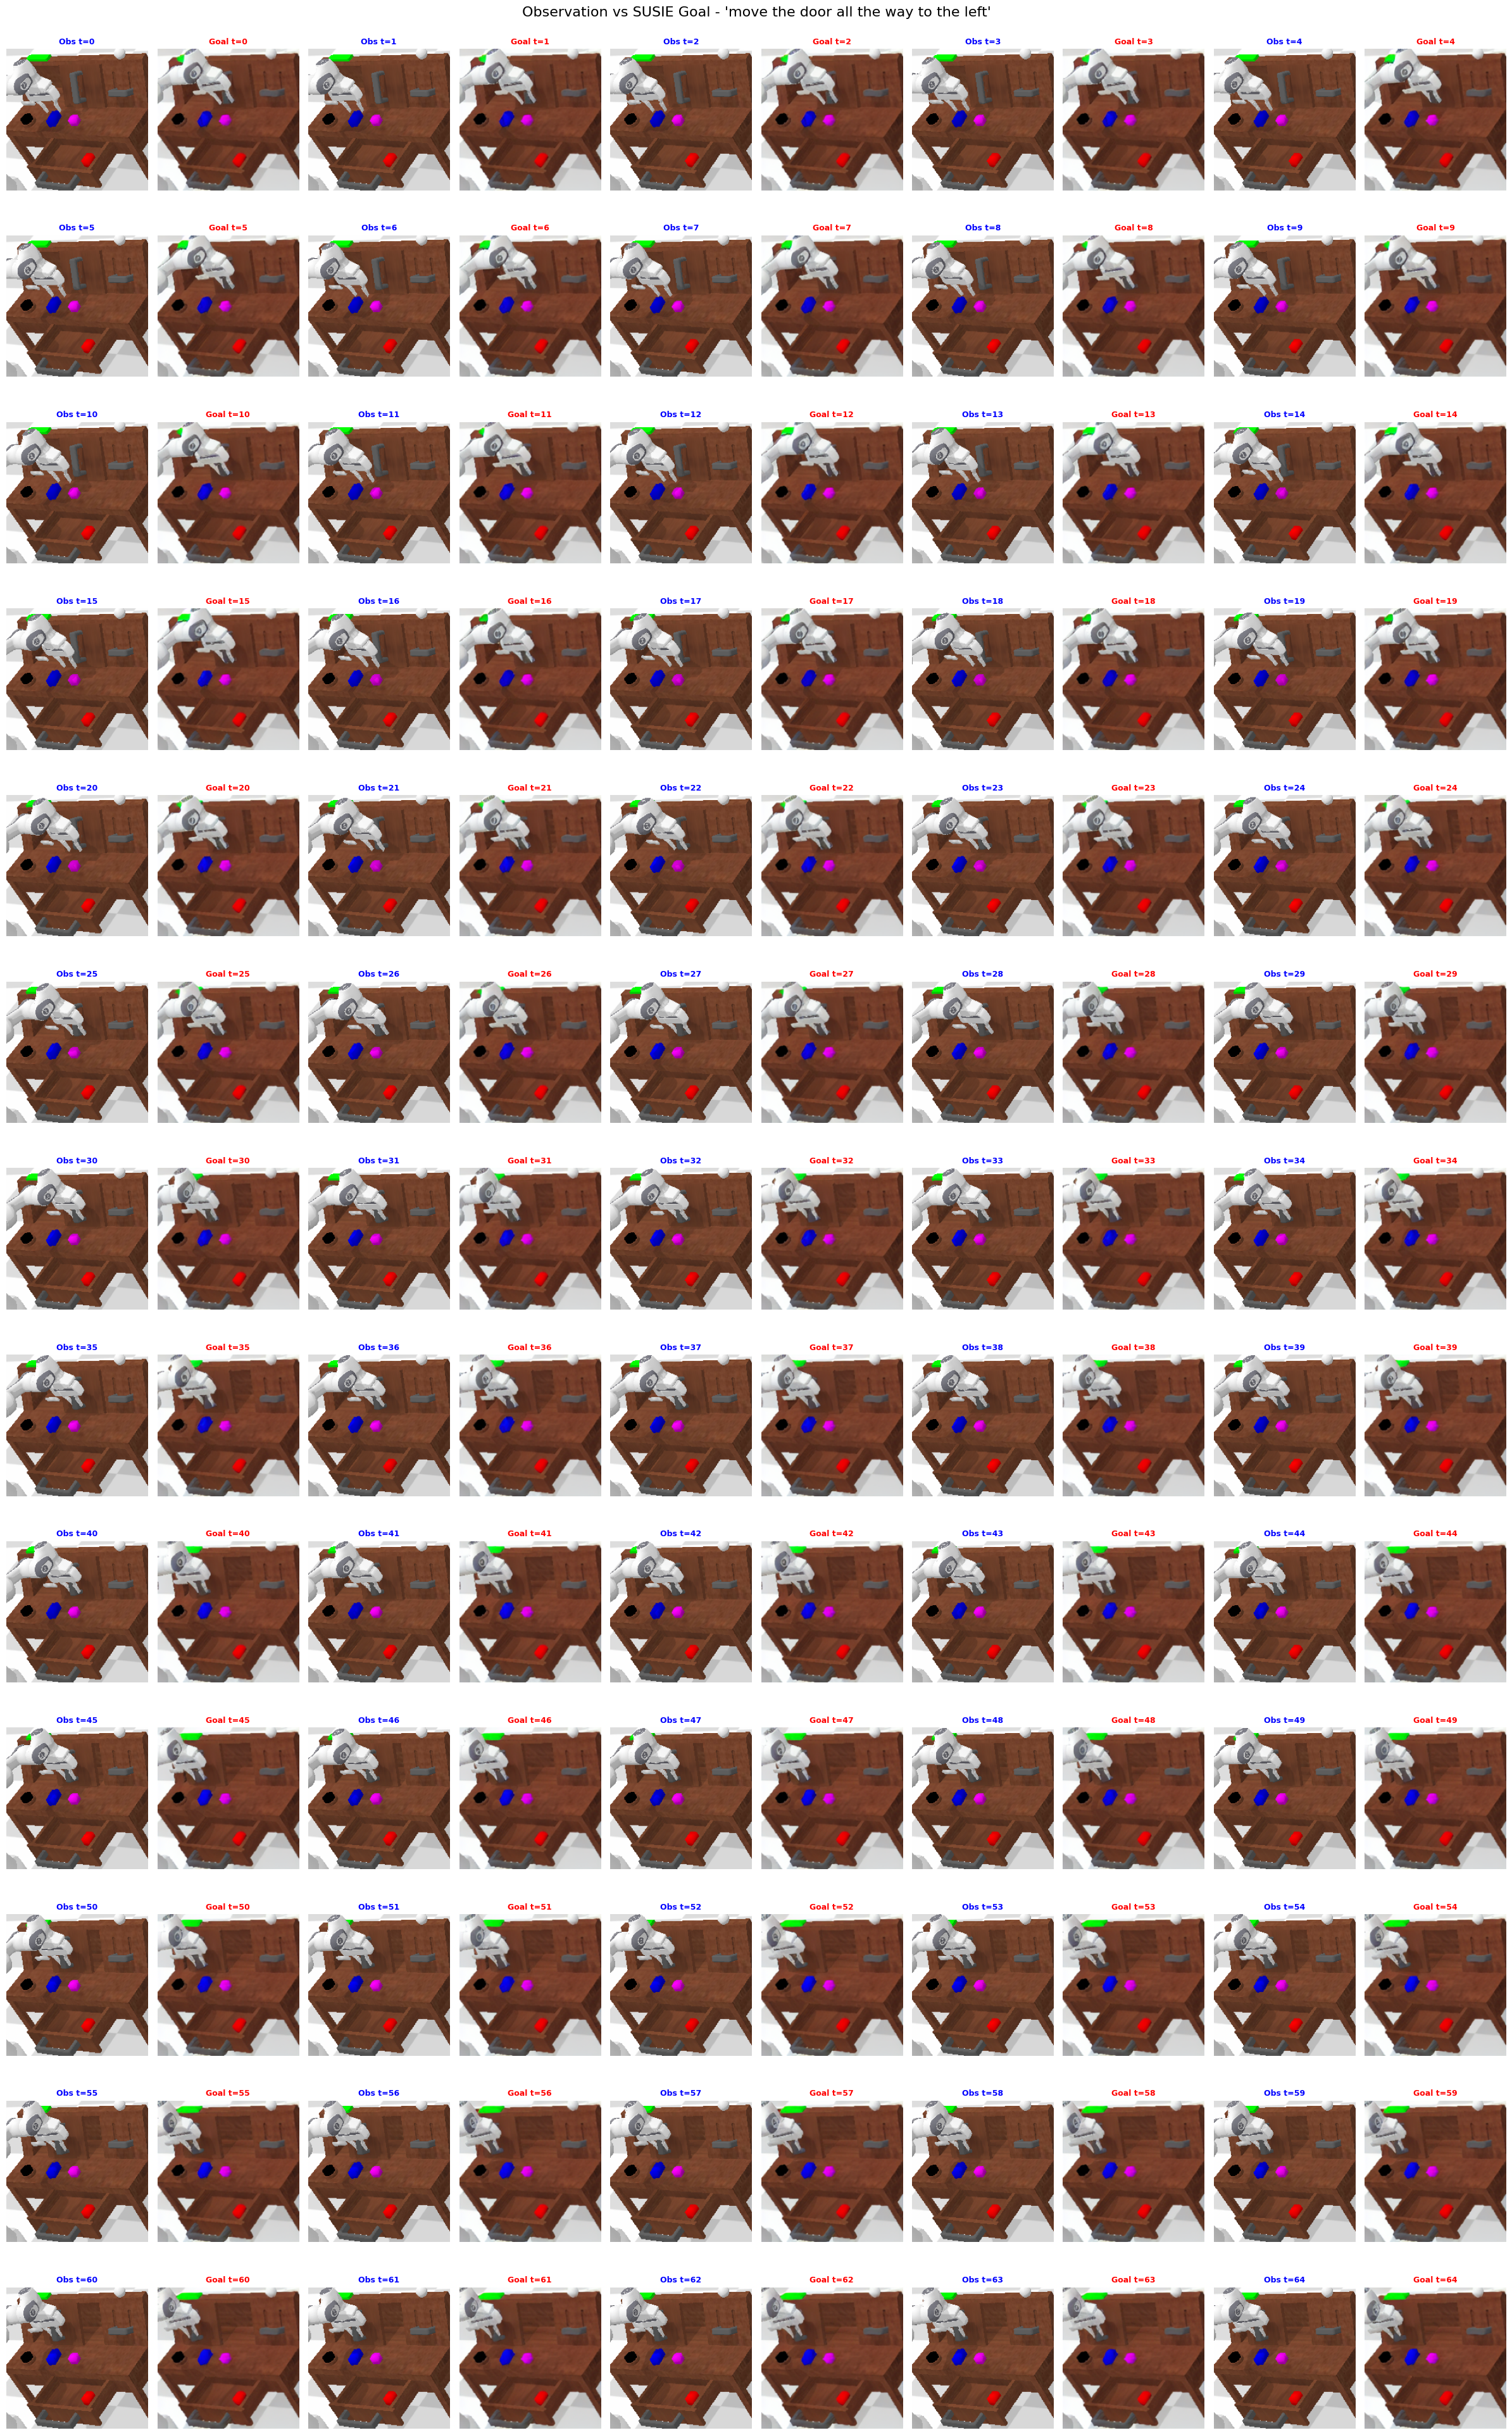

In [11]:
# Visualize entire trajectory with observations and SUSIE goals side by side
import matplotlib.pyplot as plt

traj_len = len(image_states)

# Calculate grid dimensions
cols = 5  # Number of timesteps per row
rows = (traj_len + cols - 1) // cols  # Calculate rows needed

# Create figure with side-by-side comparison
fig, axes = plt.subplots(rows, cols * 2, figsize=(24, 3*rows))
fig.suptitle(f"Observation vs SUSIE Goal - '{language_annotation}'", fontsize=16, y=0.995)

for i in range(traj_len):
    row = i // cols
    col = i % cols
    
    # Observation image (left side)
    ax_obs = axes[row, col * 2]
    ax_obs.imshow(image_states[i])
    ax_obs.set_title(f'Obs t={i}', fontsize=9, fontweight='bold', color='blue')
    ax_obs.axis('off')
    # Add blue border
    for spine in ax_obs.spines.values():
        spine.set_edgecolor('blue')
        spine.set_linewidth(2)
        spine.set_visible(True)
    
    # SUSIE goal image (right side)
    ax_goal = axes[row, col * 2 + 1]
    ax_goal.imshow(susie_goal_images[i])
    ax_goal.set_title(f'Goal t={i}', fontsize=9, fontweight='bold', color='red')
    ax_goal.axis('off')
    # Add red border
    for spine in ax_goal.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)
        spine.set_visible(True)

# Hide unused subplots
total_subplots = rows * cols
for i in range(traj_len, total_subplots):
    row = i // cols
    col = i % cols
    axes[row, col * 2].axis('off')
    axes[row, col * 2 + 1].axis('off')

plt.tight_layout()
plt.show()